In [5]:
import urllib.request
import os 
import zipfile
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile


In [12]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "catdog.zip"
download_dir = "dataset/"
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name,'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [13]:
print("number of cat images",len(os.listdir('dataset/PetImages/Cat')))
print("number of dog images",len(os.listdir('dataset/PetImages/Dog')))

number of cat images 12501
number of dog images 12501


In [14]:
try:
    os.mkdir('dataset/cats-v-dogs')
    os.mkdir('dataset/cats-v-dogs/training')
    os.mkdir('dataset/cats-v-dogs/testing')
    os.mkdir('dataset/cats-v-dogs/training/cats')
    os.mkdir('dataset/cats-v-dogs/training/dogs')
    os.mkdir('dataset/cats-v-dogs/testing/cats')
    os.mkdir('dataset/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [16]:

import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename 
        if os.path.getsize(file) > 0 :
            files.append(filename)
        else:
            print(filename + "is zero length so ignoring")
        
        training_length = int(len(files)* SPLIT_SIZE)
        testing_images = int(len(files) - training_length)
        shuffel_set = random.sample(files,len(files))
        training_set = shuffel_set[0:training_length]
        testing_set = shuffel_set[training_length:]

    for filename  in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file,destination)

    
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file,destination)

CAT_SOURCE_DIR = "dataset/PetImages/Cat/"
TRAINING_CATS_DIR = "dataset/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "dataset/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "dataset/PetImages/Dog/"
TRAINING_DOGS_DIR = "dataset/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "dataset/cats-v-dogs/testing/dogs/"


split_size = 0.9
split_data(CAT_SOURCE_DIR,TRAINING_CATS_DIR,TESTING_CATS_DIR,split_size)
split_data(DOG_SOURCE_DIR,TRAINING_DOGS_DIR,TESTING_DOGS_DIR,split_size)

666.jpgis zero length so ignoring
11702.jpgis zero length so ignoring


In [19]:
print("NUmber of training CAT images", len(os.listdir("dataset/cats-v-dogs/training/cats/")))
print("Number of testing  CAT images",len(os.listdir("dataset/cats-v-dogs/testing/cats/")))

print("NUmber of testing  DOG images ", len(os.listdir("dataset/cats-v-dogs/training/dogs/")))
print("Number of testing  DOG images",len(os.listdir("dataset/cats-v-dogs/testing/dogs/")))


NUmber of training CAT images 11250
Number of testing  CAT images 1250
NUmber of testing  DOG images  11250
Number of testing  DOG images 1250


In [29]:
Training_dir = "dataset/cats-v-dogs/training/"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range =40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(Training_dir,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150 ,150))


Validation_dir = "dataset/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(Validation_dir,
                                                              batch_size=100,
                                                              class_mode= 'binary',
                                                              target_size=(150,150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [30]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url,weights_file)


pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(weights_file)


for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer("mixed7")
print("last layer output shape :", last_layer.output_shape)

last_output = last_layer.output

last layer output shape : (None, 7, 7, 768)


In [31]:
# pre_trained_model.summary()

for layer in pre_trained_model.layers:
    print(layer.name)

input_3
conv2d_188
batch_normalization_188
activation_188
conv2d_189
batch_normalization_189
activation_189
conv2d_190
batch_normalization_190
activation_190
max_pooling2d_8
conv2d_191
batch_normalization_191
activation_191
conv2d_192
batch_normalization_192
activation_192
max_pooling2d_9
conv2d_196
batch_normalization_196
activation_196
conv2d_194
conv2d_197
batch_normalization_194
batch_normalization_197
activation_194
activation_197
average_pooling2d_18
conv2d_193
conv2d_195
conv2d_198
conv2d_199
batch_normalization_193
batch_normalization_195
batch_normalization_198
batch_normalization_199
activation_193
activation_195
activation_198
activation_199
mixed0
conv2d_203
batch_normalization_203
activation_203
conv2d_201
conv2d_204
batch_normalization_201
batch_normalization_204
activation_201
activation_204
average_pooling2d_19
conv2d_200
conv2d_202
conv2d_205
conv2d_206
batch_normalization_200
batch_normalization_202
batch_normalization_205
batch_normalization_206
activation_200
activa

In [32]:

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation ="relu")(x)
x = layers.Dense(1,activation = 'sigmoid')(x)
model = Model(pre_trained_model.input,x)


In [33]:
model.compile(optimizer=RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_generator,validation_data=validation_generator,epochs=2,verbose=1)

/home/avi/anaconda3/envs/myenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/2
187/225 [=======================>......] - ETA: 1:30 - loss: 0.2408 - acc: 0.9047

/home/avi/anaconda3/envs/myenv/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 586s 3s/step - loss: 0.2288 - acc: 0.9094 - val_loss: 0.0823 - val_acc: 0.9668
Epoch 2/2
225/225 [==============================] - 591s 3s/step - loss: 0.1538 - acc: 0.9357 - val_loss: 0.0723 - val_acc: 0.9732


<Figure size 640x480 with 0 Axes>

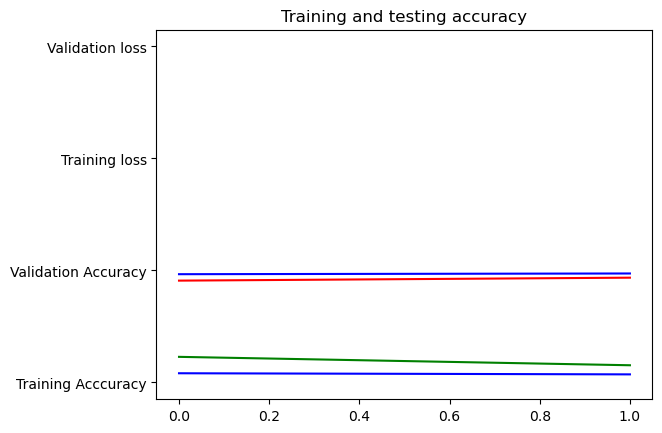

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',"Training Acccuracy")
plt.plot(epochs,val_acc,'b','Validation Accuracy')

plt.plot(epochs,loss,'g',"Training loss")
plt.plot(epochs,val_loss,'b','Validation loss')
plt.title("Training and testing accuracy")

plt.figure()

In [42]:
import numpy as np 
from keras.preprocessing import image
 
pat = "sample-images/"
for name in os.listdir(pat):
    path = '/sample-images/' + name
    img =  image.load_img(path,target_size = (150,150))
    x = image.img_to_array(img)
    x = np.expand_dims(x,   axis = 0)
    image_tensor = np.vstack([x])
    classes = model.predict(image_tensor)
    print(classes)
    print(classes[0])
    if classes[0]>0.5:
        print("cat")
    else:
        print("dog")


AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

In [50]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

a =0

pat = "/home/avi/InterviewPre/computer-vision/dataset/cats-v-dogs/testing/cats/"
for name in os.listdir(pat):
    path = pat + name
    img = image.load_img(path, target_size=(150,150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    image_tensor = np.vstack([x])
    classes = model.predict(image_tensor)
    print(str(classes))
    a = a+1

    if(a == 10):
        break
    # print(classes[0])
    # if classes[0] > 0.5:
    #     print("cat")
    # else:
    #     print("dog")


1/1 [==============================] - 0s 72ms/step
[[1.]]
1/1 [==============================] - 0s 87ms/step
[[1.]]
1/1 [==============================] - 0s 93ms/step
[[0.]]
1/1 [==============================] - 0s 117ms/step
[[1.]]
1/1 [==============================] - 0s 111ms/step
[[1.]]
1/1 [==============================] - 0s 93ms/step
[[1.]]
1/1 [==============================] - 0s 96ms/step
[[1.]]
1/1 [==============================] - 0s 113ms/step
[[0.]]
1/1 [==============================] - 0s 107ms/step
[[0.]]
1/1 [==============================] - 0s 104ms/step
[[1.0296433e-16]]


In [52]:

pat = "sample-images/dog1.png"


img = image.load_img(pat, target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
image_tensor = np.vstack([x])
classes = model.predict(image_tensor)
print(str(classes))
# a = a+1

# if(a == 10):
#     break
print(classes[0])
if classes[0] > 0.5:
    print("dog")
else:
    print("cat")

1/1 [==============================] - 0s 87ms/step
[[1.]]
[1.]
cat
